In [1]:
import numpy as np
import gym
import tensorflow as tf
import tensorflow.contrib.layers as layers
import matplotlib.pyplot as plt
from collections import deque
import random
import itertools

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
class ReplayBuffer(object):
    def __init__(self, maxlen):
        self.memory = deque(maxlen=maxlen)
        self.maxlen = maxlen
        self.size = 0
        
    def add(self, s, a, r, s2, done):
        self.memory.append((s, a, r, s2, done))
        self.size = min(self.size+1, self.maxlen)
        
    def sample(self, batch_size):
        batch = random.sample(self.memory, min(batch_size, self.size))
        
        s_batch = np.array([_[0] for _ in batch])
        a_batch = np.array([_[1] for _ in batch])
        r_batch = np.array([_[2] for _ in batch])
        s2_batch = np.array([_[3] for _ in batch])
        done_batch = [_[4] for _ in batch]
        
        return s_batch, a_batch, r_batch, s2_batch, done_batch

In [5]:
class PGAgent(object):
    def __init__(self,
                 env,
                 gamma = 0.98,
                 maxlen=10000,
                 batch_size=32):
        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        
        self.add_placeholders()
        self.build_policy_network()
        self.build_value_network()
        self.add_optimizers()
        
        self.buffer = ReplayBuffer(maxlen)
            
    def add_placeholders(self):
        state_shape = list(self.env.observation_space.shape)
        
        self.state = tf.placeholder(dtype=tf.float32, shape=[None] + state_shape)
        self.action = tf.placeholder(dtype=tf.int32, shape=[None])
        self.action_onehot = tf.one_hot(indices=self.action, depth=env.action_space.n)
        self.target = tf.placeholder(dtype=tf.float32, shape=[None])
        self.policy_lr = tf.placeholder(dtype=tf.float32, shape=[])
        self.value_lr = tf.placeholder(dtype=tf.float32, shape=[])
    
    def build_policy_network(self, scope='policy'):
        with tf.variable_scope(scope):
            h = layers.fully_connected(inputs=self.state,
                                       num_outputs=100,
                                       scope='fc1',
                                       # activation_fn=tf.tanh,
                                       reuse=tf.AUTO_REUSE)
            h = layers.fully_connected(inputs=h,
                                       num_outputs=50,
                                       scope='fc2',
                                       # activation_fn=tf.tanh,
                                       reuse=tf.AUTO_REUSE)
            logits = layers.fully_connected(inputs=h,
                                            num_outputs=self.env.action_space.n,
                                            activation_fn=None,
                                            scope='logits',
                                            reuse=tf.AUTO_REUSE)
            self.logits=logits
            self.probs = tf.nn.softmax(logits)
            self.logprob = tf.log(tf.reduce_sum(self.probs * self.action_onehot, axis=1))
            
    def build_value_network(self, scope='value'):
        with tf.variable_scope(scope):
            h = layers.fully_connected(inputs=self.state,
                                       num_outputs=300,
                                       scope='vfc1',
                                       activation_fn=tf.tanh,
                                       reuse=tf.AUTO_REUSE)
            h = layers.fully_connected(inputs=h,
                                       num_outputs=100,
                                       scope='vfc2',
                                       activation_fn=tf.tanh,
                                       reuse=tf.AUTO_REUSE)
            _value = layers.fully_connected(inputs=h,
                                            num_outputs=1,
                                            reuse=tf.AUTO_REUSE,
                                            scope='value',
                                            activation_fn=None)    
            self.value = tf.reshape(_value, shape=[-1])
            
    def add_optimizers(self):
        advantage = self.target - self.value
        policy_loss = tf.reduce_mean(tf.multiply(-self.logprob, advantage))
        policy_opt = tf.train.AdamOptimizer(learning_rate=self.policy_lr)
        self.policy_update = policy_opt.minimize(
            policy_loss,
            var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope='policy'))
        self.pgv = policy_opt.compute_gradients(
            policy_loss,
            var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
            scope='policy'))
        
        value_loss = tf.reduce_mean(tf.square(self.target - self.value))
        self.loss = value_loss
        value_opt = tf.train.AdamOptimizer(learning_rate=self.value_lr)
        self.value_update = value_opt.minimize(
            value_loss,
            var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
            scope='value'))

    def sample_action(self, state):
        probs = sess.run(self.probs, {self.state : [state]})[0]
        return np.random.choice(env.action_space.n, p=probs)
    
    def update(self, state, action, reward, next_state, done,
               value_lr = 1e-3, policy_lr = 1e-3):
        self.buffer.add(state, action, reward, next_state, done)
        
        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)
        values = sess.run(self.value, {self.state : next_states})
        targets = rewards + self.gamma * np.where(dones, np.zeros_like(values), values)

        # Experience replay is only used to learn the value function
        sess.run([self.value_update],
                 {self.state : states,
                  self.action : actions,
                  self.target : targets,
                  self.policy_lr : policy_lr,
                  self.value_lr : value_lr})

        # Use only the current action to update the policy
        value = sess.run(self.value, {self.state : [next_state]})[0]
        if done:
            target = reward
        else:
            target = reward + self.gamma * value
        
        sess.run([self.policy_update],
                 {self.state : [state],
                  self.action : [action],
                  self.target : [target],
                  self.policy_lr : policy_lr,
                  self.value_lr : value_lr})
        
        loss = sess.run(self.loss, {self.state : states,
                                    self.action : actions,
                                    self.target : targets})

        return loss

In [6]:
env = gym.make('CartPole-v0')

tf.reset_default_graph()
agent = PGAgent(env, gamma=0.999, batch_size=4096, maxlen=250000)
n_episodes = 100
lr_init = 2.e-3
lr = lr_init
rewards = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    cum_reward = 0
    cum_loss = 0
    for i in range(n_episodes):
        t = 0
        state = env.reset()
        done = False
        episode_reward = 0
        episode_loss = 0
        while not done:
            action = agent.sample_action(state)
            next_state, reward, done, _ = env.step(action)
            loss = agent.update(state, action, reward, next_state, done, lr, lr)
            episode_loss += loss
            episode_reward += reward
            state = next_state
            t += 1
        
        rewards.append(episode_reward)
        cum_reward += episode_reward
        cum_loss += episode_loss / t
        if i % 10 == 9:
            print('Episode {}: average reward: {}, average loss: {}'.\
                  format(i, cum_reward / 10, cum_loss / 10))
            cum_reward = 0
            cum_loss = 0

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Episode 9: average reward: 26.1, average loss: 23.382117697291896
Episode 19: average reward: 51.4, average loss: 8.025098731593323
Episode 29: average reward: 82.8, average loss: 10.265485687698689
Episode 39: average reward: 171.7, average loss: 20.07784753478148
Episode 49: average reward: 200.0, average loss: 43.79526347923279
Episode 59: average reward: 200.0, average loss: 52.675162096023556
Episode 69: average reward: 200.0, average loss: 46.95526805114746
Episode 79: average reward: 200.0, average loss: 45.21848092269899
Episode 89: average reward: 200.0, average loss: 46.7121678943634
Episode 99: average reward: 192.4, average loss: 48.96854947121578


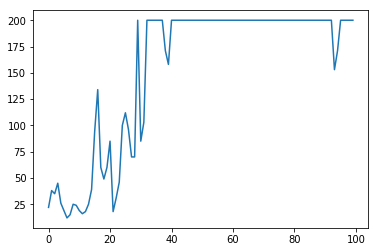

In [7]:
plt.plot(range(n_episodes), rewards)